Fold 1: λ=0.001, logreg_err=0.0330 | k=1, knn_err=0.1604 | baseline_err=0.8349
Fold 2: λ=0.001, logreg_err=0.0332 | k=1, knn_err=0.1517 | baseline_err=0.8341
Fold 3: λ=0.01, logreg_err=0.0521 | k=1, knn_err=0.1991 | baseline_err=0.8341
Fold 4: λ=0.001, logreg_err=0.0237 | k=1, knn_err=0.1896 | baseline_err=0.8341
Fold 5: λ=0.001, logreg_err=0.0427 | k=1, knn_err=0.2085 | baseline_err=0.8341
Fold 6: λ=0.001, logreg_err=0.0284 | k=1, knn_err=0.1943 | baseline_err=0.8341
Fold 7: λ=0.001, logreg_err=0.0379 | k=1, knn_err=0.1611 | baseline_err=0.8341
Fold 8: λ=0.001, logreg_err=0.0569 | k=1, knn_err=0.1896 | baseline_err=0.8294
Fold 9: λ=0.01, logreg_err=0.0379 | k=1, knn_err=0.1896 | baseline_err=0.8341
Fold 10: λ=0.001, logreg_err=0.0521 | k=1, knn_err=0.1991 | baseline_err=0.8341

Two-level CV results (per outer fold):
   outer_fold  lambda_selected  logreg_Etest  k_selected  knn_Etest  \
0           1            0.001      0.033019           1   0.160377   
1           2            0.00

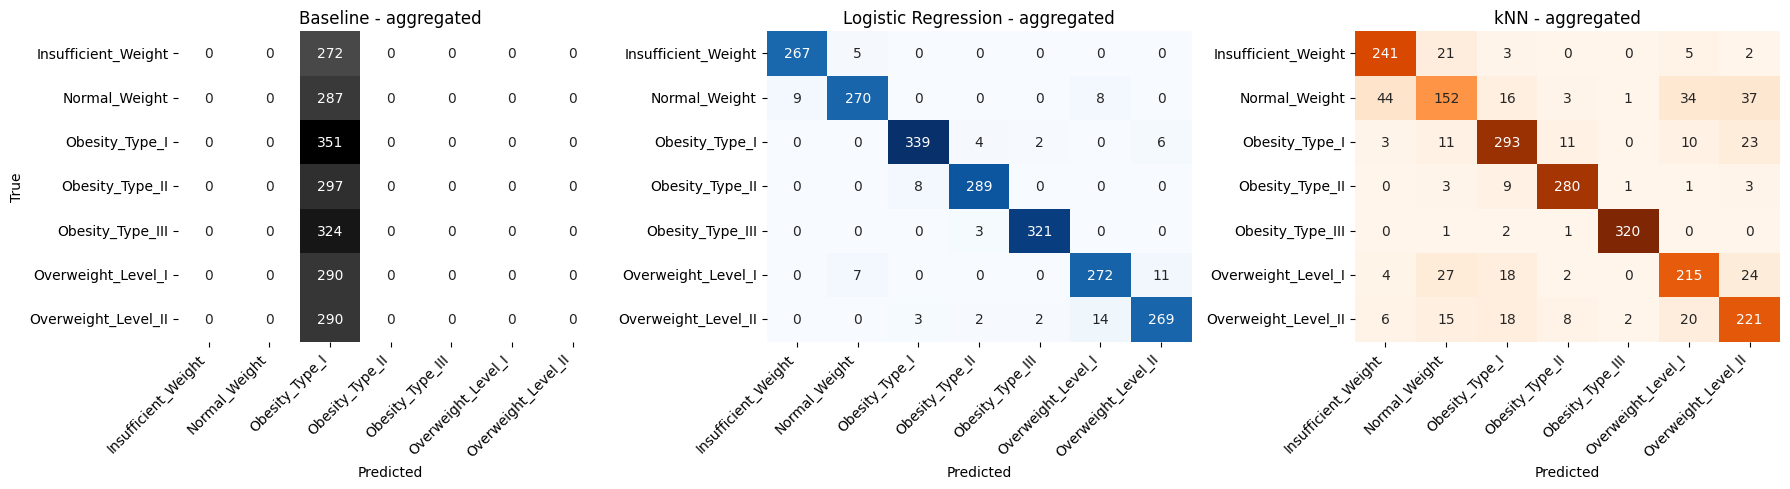


McNemar pairwise tests (on correctness):
LogReg vs kNN: b=339, c=34, chi2_stat=247.7641, p=0.0000e+00
LogReg vs Baseline: b=1688, c=12, chi2_stat=1650.3676, p=0.0000e+00
kNN vs Baseline: b=1429, c=58, chi2_stat=1262.2058, p=0.0000e+00

Final logistic trained on full data with lambda = 0.001 (C=1000)

Top 15 features by average absolute logistic coefficient:
                        feature  avg_abs_coef
0                        Weight     77.944310
1                        Height     19.756937
2                   Gender_Male     11.090270
3                          FCVC      6.979343
4                           NCP      4.969393
5                           FAF      4.528843
6                   MTRANS_Bike      3.714480
7               CAEC_Frequently      2.824197
8                           Age      2.773408
9  MTRANS_Public_Transportation      2.318479


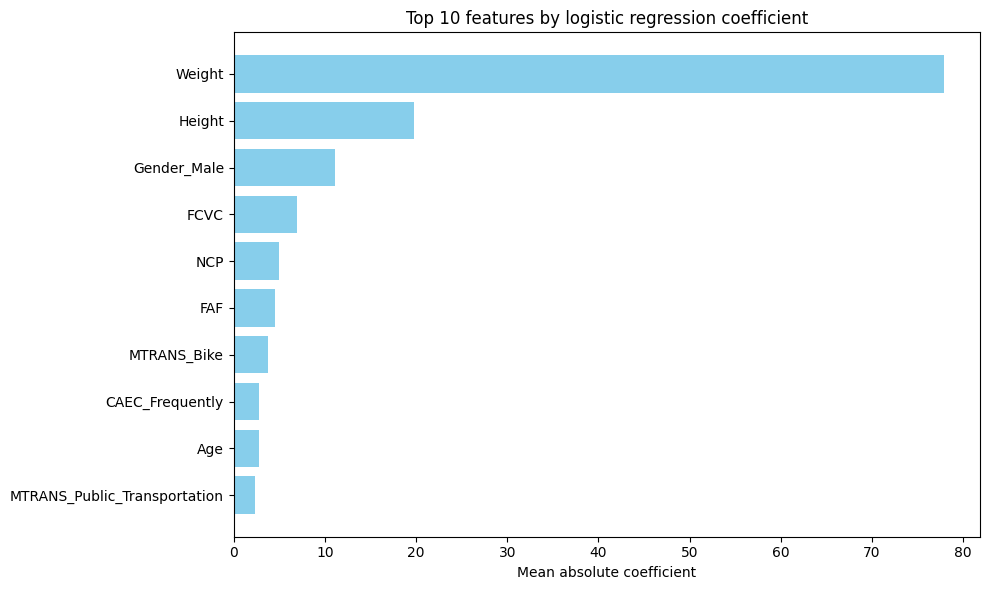

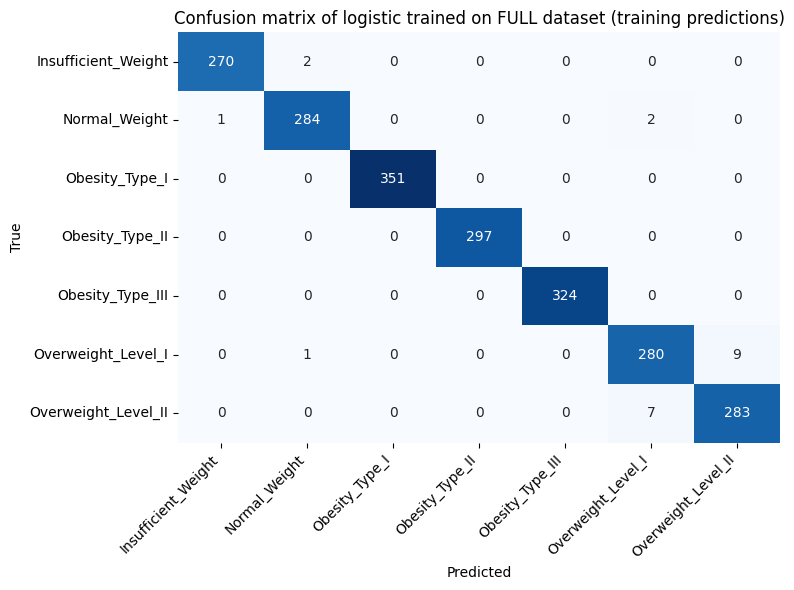

In [12]:

import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2

# -----------------------
# 0. Settings / hypergrids
# -----------------------
RANDOM_STATE = 42
OUTER_FOLDS = 10
INNER_FOLDS = 10

# lambda grid (regularization strength). sklearn uses C = 1/lambda
lambda_grid = [1e-3, 1e-2, 1e-1, 1.0, 10.0]
C_grid = [1.0 / l for l in lambda_grid]

k_grid = [1, 3, 5, 7]  # k values to try for kNN

# -----------------------
# 1. Load data (your path)
# -----------------------
df = pd.read_csv('../data/ObesityDataSet_Clean.csv')  # adjust path if needed
X = df.drop(columns=['NObeyesdad']).copy()
y = df['NObeyesdad'].copy()

# -----------------------
# 2. One-hot encode categorical features (no leakage since only encoding)
# -----------------------
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Convert to numpy arrays for speed (GridSearchCV / Pipeline accept DataFrame too)
X_all = X.values
y_all = y.values
feature_names = X.columns.tolist()

# -----------------------
# 3. Prepare outer CV
# -----------------------
outer_cv = StratifiedKFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)
inner_cv = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Pipelines (scale inside CV)
pipe_log = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, solver='lbfgs'))
])

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

# GridSearchCV objects (we will run them separately in each outer fold)
param_grid_log = {'clf__C': C_grid}
param_grid_knn = {'clf__n_neighbors': k_grid}

# Storage for outer-fold results
rows = []
y_true_all = []
y_pred_log_all = []
y_pred_knn_all = []
y_pred_base_all = []

selected_lambdas = []  # store lambda selected (as lambda, not C)
selected_ks = []

fold_idx = 0
for train_idx, test_idx in outer_cv.split(X_all, y_all):
    fold_idx += 1
    X_tr, X_te = X_all[train_idx], X_all[test_idx]
    y_tr, y_te = y_all[train_idx], y_all[test_idx]

    # ---- Baseline: predict most common class in outer training set ----
    most_common = Counter(y_tr).most_common(1)[0][0]
    y_pred_baseline = np.array([most_common] * len(y_te))

    # record baseline error
    e_baseline = 1.0 - accuracy_score(y_te, y_pred_baseline)

    # ---- Inner CV: logistic regression ----
    gs_log = GridSearchCV(pipe_log, param_grid_log, cv=inner_cv, scoring='accuracy', n_jobs=-1)
    gs_log.fit(X_tr, y_tr)
    best_C = gs_log.best_params_['clf__C']
    best_lambda = 1.0 / best_C
    selected_lambdas.append(best_lambda)

    # retrain best estimator on full outer training set and eval on outer test
    best_log = gs_log.best_estimator_
    y_pred_log = best_log.predict(X_te)
    e_log = 1.0 - accuracy_score(y_te, y_pred_log)

    # ---- Inner CV: kNN ----
    gs_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=inner_cv, scoring='accuracy', n_jobs=-1)
    gs_knn.fit(X_tr, y_tr)
    best_k = gs_knn.best_params_['clf__n_neighbors']
    selected_ks.append(best_k)

    best_knn = gs_knn.best_estimator_
    y_pred_knn = best_knn.predict(X_te)
    e_knn = 1.0 - accuracy_score(y_te, y_pred_knn)

    # collect per-fold info
    rows.append({
        'outer_fold': fold_idx,
        'lambda_selected': best_lambda,
        'logreg_Etest': e_log,
        'k_selected': best_k,
        'knn_Etest': e_knn,
        'baseline_Etest': e_baseline,
        'n_test': len(y_te)
    })

    # extend aggregated predictions / truths for statistical tests & confusion matrices
    y_true_all.extend(y_te.tolist())
    y_pred_log_all.extend(y_pred_log.tolist())
    y_pred_knn_all.extend(y_pred_knn.tolist())
    y_pred_base_all.extend(y_pred_baseline.tolist())

    print(f"Fold {fold_idx}: λ={best_lambda:.4g}, logreg_err={e_log:.4f} | k={best_k}, knn_err={e_knn:.4f} | baseline_err={e_baseline:.4f}")

# -----------------------
# 4. Create results table (like Table 2)
# -----------------------
results_table = pd.DataFrame(rows)
results_table['logreg_Etest_percent'] = results_table['logreg_Etest'] * 100
results_table['knn_Etest_percent'] = results_table['knn_Etest'] * 100
results_table['baseline_Etest_percent'] = results_table['baseline_Etest'] * 100

# Print per-fold table
print("\nTwo-level CV results (per outer fold):")
print(results_table[['outer_fold','lambda_selected','logreg_Etest','k_selected','knn_Etest','baseline_Etest']])

# Aggregate mean test errors
mean_err_log = results_table['logreg_Etest'].mean()
mean_err_knn = results_table['knn_Etest'].mean()
mean_err_base = results_table['baseline_Etest'].mean()

summary_df = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'kNN'],
    'Mean Error Rate': [mean_err_base, mean_err_log, mean_err_knn],
    'Mean Accuracy': [1-mean_err_base, 1-mean_err_log, 1-mean_err_knn]
})
print("\nAggregated performance (averaged over outer folds):")
print(summary_df)

# -----------------------
# 5. Confusion matrices (aggregated across outer folds)
# -----------------------
labels = np.unique(y_all)  # class labels (strings)
cm_log = confusion_matrix(y_true_all, y_pred_log_all, labels=labels)
cm_knn = confusion_matrix(y_true_all, y_pred_knn_all, labels=labels)
cm_base = confusion_matrix(y_true_all, y_pred_base_all, labels=labels)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(cm_base, annot=True, fmt='d', ax=axs[0], cmap='Greys', cbar=False)
axs[0].set_title('Baseline - aggregated')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_xticklabels(labels, rotation=45, ha='right')
axs[0].set_yticklabels(labels, rotation=0)

sns.heatmap(cm_log, annot=True, fmt='d', ax=axs[1], cmap='Blues', cbar=False)
axs[1].set_title('Logistic Regression - aggregated')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('')
axs[1].set_xticklabels(labels, rotation=45, ha='right')
axs[1].set_yticklabels(labels, rotation=0)

sns.heatmap(cm_knn, annot=True, fmt='d', ax=axs[2], cmap='Oranges', cbar=False)
axs[2].set_title('kNN - aggregated')
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('')
axs[2].set_xticklabels(labels, rotation=45, ha='right')
axs[2].set_yticklabels(labels, rotation=0)

plt.tight_layout()
plt.show()

# -----------------------
# 6. McNemar's test pairwise (on correctness)
#    We compute for each pair:
#       b = #instances A correct & B wrong
#       c = #instances A wrong   & B correct
#    Then use continuity-corrected chi-square:
#       stat = (|b-c|-1)^2 / (b+c)
# -----------------------
def mcnemar_from_preds(y_true, predA, predB):
    y_true = np.array(y_true)
    predA = np.array(predA)
    predB = np.array(predB)
    A_corr = (predA == y_true)
    B_corr = (predB == y_true)
    b = np.sum((A_corr) & (~B_corr))
    c = np.sum((~A_corr) & (B_corr))
    if b + c == 0:
        stat = 0.0
        p = 1.0
    else:
        stat = (abs(b - c) - 1)**2 / (b + c)  # continuity correction
        p = 1.0 - chi2.cdf(stat, df=1)
    return {'b': int(b), 'c': int(c), 'stat': float(stat), 'p_value': float(p)}

pairs = [
    ('LogReg vs kNN', y_pred_log_all, y_pred_knn_all),
    ('LogReg vs Baseline', y_pred_log_all, y_pred_base_all),
    ('kNN vs Baseline', y_pred_knn_all, y_pred_base_all),
]

print("\nMcNemar pairwise tests (on correctness):")
for name, predA, predB in pairs:
    res = mcnemar_from_preds(y_true_all, predA, predB)
    print(f"{name}: b={res['b']}, c={res['c']}, chi2_stat={res['stat']:.4f}, p={res['p_value']:.4e}")

# -----------------------
# 7. Final logistic: choose the most common lambda across folds, retrain on full dataset,
#    show top features by absolute coefficient (averaged across classes)
# -----------------------
most_common_lambda = Counter(selected_lambdas).most_common(1)[0][0]
best_C_full = 1.0 / most_common_lambda
pipe_final_log = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(C=best_C_full, max_iter=3000, solver='lbfgs'))
])
pipe_final_log.fit(X_all, y_all)
print(f"\nFinal logistic trained on full data with lambda = {most_common_lambda:.4g} (C={best_C_full:.4g})")

# Extract coefficients
coefs = pipe_final_log.named_steps['clf'].coef_  # shape (n_classes, n_features)
# For feature importance, average absolute coef across classes
avg_abs_coef = np.mean(np.abs(coefs), axis=0)
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'avg_abs_coef': avg_abs_coef
}).sort_values('avg_abs_coef', ascending=False).reset_index(drop=True)

print("\nTop 15 features by average absolute logistic coefficient:")
print(feat_imp.head(10))


top_n = 10  # number of features to display
plt.figure(figsize=(10,6))
plt.barh(feat_imp['feature'][:top_n][::-1], feat_imp['avg_abs_coef'][:top_n][::-1], color='skyblue')
plt.xlabel('Mean absolute coefficient')
plt.title('Top 10 features by logistic regression coefficient')
plt.tight_layout()
plt.savefig('feature_importance.png')  
plt.show()

# Confusion matrix for final logistic on full data (train predictions)
y_pred_full_log = pipe_final_log.predict(X_all)
cm_full_log = confusion_matrix(y_all, y_pred_full_log, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm_full_log, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion matrix of logistic trained on FULL dataset (training predictions)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(labels))+0.5, labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels))+0.5, labels=labels, rotation=0)
plt.tight_layout()
plt.show()